# Predicting donor-specific cytokine effects on PBMCs

In this tutorial, we predict the donor-specific cytokine effect on PBMCs. The dataset comprises almost ten million cells from 12 different donors, whose samples were treated with 90 different cytokines. More information on the data can be found [here](https://www.parsebiosciences.com/datasets/10-million-human-pbmcs-in-a-single-experiment/). 

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2

As the dataset is particularly large, we use [rapids-single-cell](https://rapids-singlecell.readthedocs.io/en/latest/index.html) which allows us to leverage GPU acceleration for preprocessing and downstream tasks. This notebook is executed on a A100 GPU with 80GB memory, as well as 500GB CPU memory. 

In [2]:
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", SettingWithCopyWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import jax
import functools
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import flax.linen as nn
import optax
import cellflow
from cellflow.model import CellFlow
import cellflow.preprocessing as cfpp
from cellflow.utils import match_linear
from cellflow.plotting import plot_condition_embedding
from cellflow.preprocessing import transfer_labels, compute_wknn, reconstruct_pca
from cellflow.metrics import compute_r_squared, compute_e_distance


In [70]:
# adata_train.write_h5ad("pbmc_cytokines_train.h5ad")
# adata_test.write_h5ad("pbmc_cytokines_test.h5ad")
adata_train = ad.read_h5ad("pbmc_cytokines_train.h5ad")
adata_test = ad.read_h5ad("pbmc_cytokines_test.h5ad")

## Setting up the CellFlow model

We are now ready to setup the {class}`~cellflow.model.CellFlow` model.

Therefore, we first choose the flow matching solver. We select the solver `"otfm"`, which deterministically maps a cell to its perturbed equivalent. If we wanted to incorporate stochasticity on single-cell level, we would select `"genot"`.

In [100]:
cf = CellFlow(adata_train, solver="otfm")

## Preparing {class}`~cellflow.model.CellFlow`'s data handling with {meth}`~cellflow.model.CellFlow.prepare_data`

We now prepare the data. Therefore, we have to choose the sample representation, i.e. the space the (measure and generated) cells live in. We use {attr}`obsm['X_pca'] <anndata.AnnData.obsm>` as computed above. Moreover, we set the control key to {attr}`obs['is_control'] <anndata.AnnData.obs>`, as defined above.

The `perturbation_covariates` indicates the external intervention, i.e. the cytokine treatment. We define a key (of arbitrary name) `"cytokine_treatment"` for this, and have the values be tuples with the perturbation and potential perturbation covariates. As we don't have a perturbation covariate (e.g. always the same dose), we only have one tuple, and as we don't observe combinations of treatments, the tuple has length 1. We use ESM2 embeddings for representing the cytokines, which we have precomputed already for the purpose of this notebook, saved in {attr}`uns['esm2_embeddings'] <anndata.AnnData.uns>`. Thus, we pass the information that `"esm2_embeddings"` stores embeddings of the {attr}`obs['cytokine'] <anndata.AnnData.obs>` treatments via `perturbation_covariate_reps`.

The sample covariate describes the cellular context independent of the perturbation. In our case, these are donors, and given in the {attr}`obs['donor'] <anndata.AnnData.obs>` column. We use the mean of the control sample as donor representation, precomputed and saved in {attr}`uns['donor_embeddings'] <anndata.AnnData.uns>`. We thus pass this piece of information to {class}`~cellflow.model.CellFlow` via `sample_covariate_reps`. 

It remains to define `split_covariates`, according to which {class}`~cellflow.model.CellFlow` trains and predicts perturbations. In effect, `split_covariates` defines how to split the control distributions, and often coincides with `sample_covariates`. This ensure that we don't learn a mapping from the control distribution of donor A to a perturbed population of donor B, but only within the same donor. 

Finally, we can pass `max_combination_length` and `null_value`. These are relevant for combinations of treatments, which doesn't apply for this use case, as we don't want to predict combinationatorial effects of cytokines. In particular, `max_combination_length` is the maximum number of combinations of cytokines which we train on or we want to eventually predict for. The null value is the token representing no treatment, e.g. relevant when we have a treatment with fewer interventions than `max_combination_length`, see tutorials with combinatorial treatments as examples.

In [117]:
cf.prepare_data(
    sample_rep = "X_pca",
    control_key = "is_control",
    perturbation_covariates = {"cytokine_treatment": ("cytokine",)},
    perturbation_covariate_reps = {"cytokine_treatment": "esm2_embeddings"},
    sample_covariates = ["donor"],
    sample_covariate_reps = {"donor": "donor_embeddings"},
    split_covariates = ["donor"],
    max_combination_length = 1,
    null_value = 0.0,
)

[########################################] | 100% Completed | 3.24 sms
[########################################] | 100% Completed | 1.24 sms


In [118]:
adatas_train_subsampled = []
for cond in adata_train.obs["condition"].unique(): # as we have many conditions, this might take a few minutes
    adatas_train_subsampled.append(sc.pp.subsample(adata_train[adata_train.obs["condition"]==cond], n_obs=1000, copy=True))

adata_train_for_validation = ad.concat(adatas_train_subsampled)

adatas_test_subsampled = []
for cond in adata_test.obs["condition"].unique():
    adatas_test_subsampled.append(sc.pp.subsample(adata_test[adata_test.obs["condition"]==cond], n_obs=2000, copy=True))

adata_test_for_validation = ad.concat(adatas_test_subsampled)


As we require the embeddings for evaluation as well, we need to copy {attr}`adata <anndata.AnnData.uns>` 

In [ ]:
adata_train_for_validation.uns = adata_train.uns.copy()
adata_test_for_validation.uns = adata_test.uns.copy()

cf.prepare_validation_data(
    adata_train_for_validation,
    name="train",
    n_conditions_on_log_iteration=10,
    n_conditions_on_train_end=10,
)

cf.prepare_validation_data(
    adata_test_for_validation,
    name="test",
    n_conditions_on_log_iteration=None,
    n_conditions_on_train_end=None,
)

[########################################] | 100% Completed | 304.92 ms
[########################################] | 100% Completed | 1.24 sms
[########################################] | 100% Completed | 103.03 ms
[########################################] | 100% Completed | 101.96 ms


In [ ]:
layers_before_pool = {
    "cytokine_treatment": {"layer_type": "mlp", "dims": [1024, 1024], "dropout_rate": 0.5},
    "donor": {"layer_type": "mlp", "dims": [256, 256], "dropout_rate": 0.0},
}

layers_after_pool = {
    "layer_type": "mlp", "dims": [1024, 1024], "dropout_rate": 0.0,
}

In [ ]:
match_fn = functools.partial(match_linear, epsilon=0.5, tau_a=1.0, tau_b=1.0)

In [ ]:
cf.prepare_model(
    encode_conditions=True,
    condition_mode="deterministic",
    regularization=0.0,
    pooling="attention_token",
    pooling_kwargs={},
    layers_before_pool=layers_before_pool,
    layers_after_pool=layers_after_pool,
    condition_embedding_dim=256,
    cond_output_dropout=0.9,
    condition_encoder_kwargs={},
    pool_sample_covariates=True,
    time_freqs=1024,
    time_encoder_dims=[1024, 1024, 1024],
    time_encoder_dropout=0.0,
    hidden_dims=[2048, 2048, 2048],
    hidden_dropout=0.0,
    decoder_dims=[4096, 4096, 4096],
    vf_act_fn=nn.silu,
    vf_kwargs=None,
    flow={"constant_noise": 0.5},
    match_fn=match_fn,
    optimizer=optax.MultiSteps(optax.adam(5e-5), 20),
    solver_kwargs={},
    layer_norm_before_concatenation=False,
    linear_projection_before_concatenation=False,
)

In [ ]:
metrics_callback = cellflow.training.Metrics(metrics=["r_squared", "mmd", "e_distance"])
decoded_metrics_callback = cellflow.training.PCADecodedMetrics(ref_adata=adata_train, metrics=["r_squared"])
wandb_callback = cellflow.training.WandbLogger(project="cellflow_tutorials", out_dir="~", config={"name": "100m_pbmc"})

# we don't pass the wandb_callback as it requires a user-specific account, but recommend setting it up
callbacks = [metrics_callback, decoded_metrics_callback]


In [125]:
cf.train(
    num_iterations=1_000_00,
    batch_size=1024,
    callbacks=callbacks,
    valid_freq=1,
    prefetch_factor=3,
    num_workers=124,
)

  0%|          | 2/100000 [00:15<185:38:18,  6.68s/it]

In [ ]:
cf.trainer.training_logs["train_e_distance_mean"]

[np.float32(25.282995),
 np.float32(18.223352),
 np.float32(49.871986),
 np.float32(31.085644)]

We can now investigate some training statistics, stored by the {class}`~cellflow.training.CellFlowTrainer`.

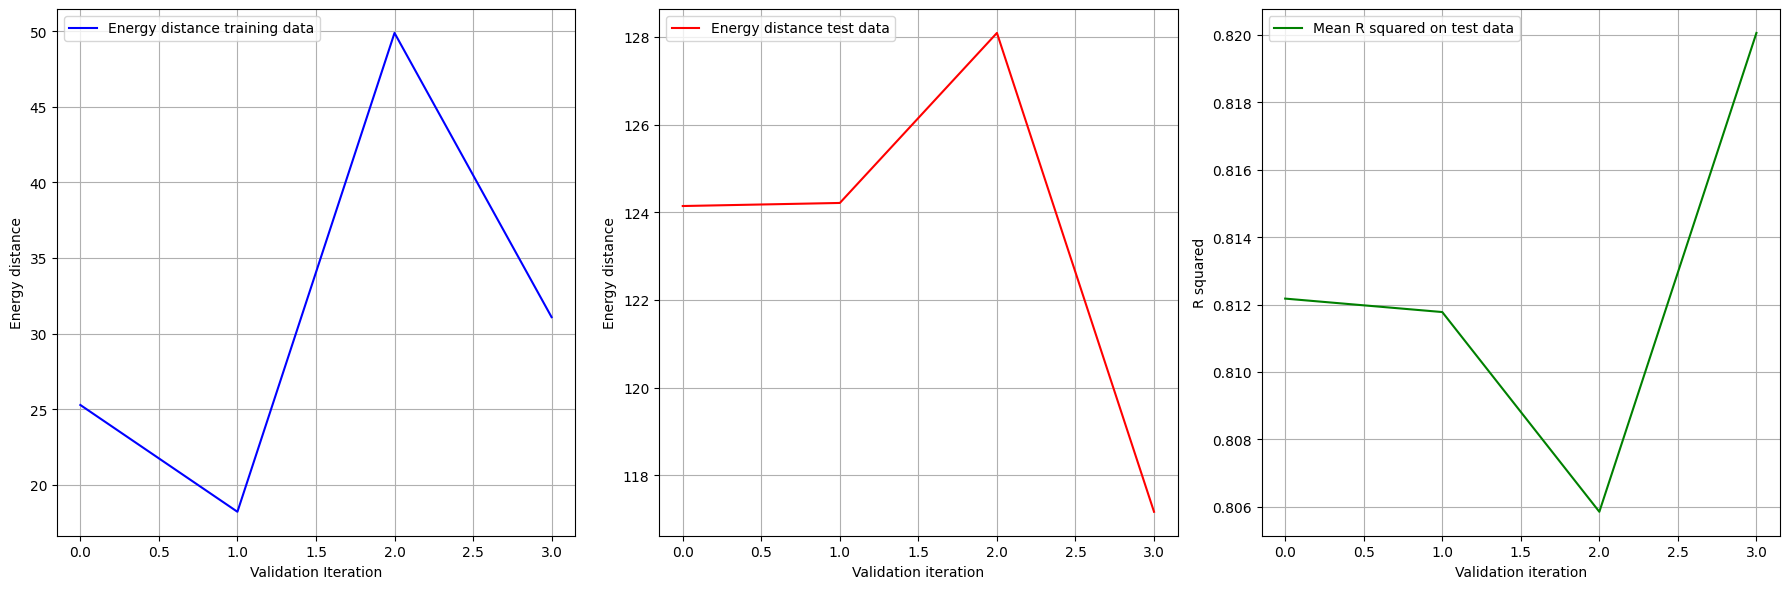

In [ ]:
e_distances_train = cf.trainer.training_logs["train_e_distance_mean"]
e_distances_test = cf.trainer.training_logs["test_e_distance_mean"]
r_squared_test   = cf.trainer.training_logs["pca_decoded_test_r_squared_mean"]

iterations_train = np.arange(len(e_distances_train))
iterations_test  = np.arange(len(e_distances_test))
iterations_r2    = np.arange(len(r_squared_test))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(iterations_train, e_distances_train, linestyle='-', color='blue', label='Energy distance training data')
axes[0].set_xlabel('Validation Iteration')
axes[0].set_ylabel('Energy distance')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(iterations_test, e_distances_test, linestyle='-', color='red', label='Energy distance test data')
axes[1].set_xlabel('Validation iteration')
axes[1].set_ylabel('Energy distance')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(iterations_r2, r_squared_test, linestyle='-', color='green', label='Mean R squared on test data')
axes[2].set_xlabel('Validation iteration')
axes[2].set_ylabel('R squared')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()


## Investigating the learnt latent space

We can visualize the learnt latent space for any condition using {meth}`~CellFlow.get_condition_embedding`. Therefore, we have to provide a {class}`~pandas.DataFrame` with the same structure of {attr}`adata.obs <anndata.AnnData.obs>` (at least the columns which we used for {meth}`~cellflow.model.CellFlow.prepare_data`). Note that the embedding is independent of the cells, we thus don't need to pass the cellular representation. Moreover, {meth}`~cellflow.model.CellFlow.get_condition_embedding` returns both the learnt mean embedding and the logvariance. The latter is 0 when `condition_mode="stochastic"`, hence we now only visualize the learnt mean. 
For now, let's use all conditions, but indicate whether they're seen during training or not:

In [21]:
covariate_data_train = adata_train[adata_train.obs["cytokine"]!="PBS"].obs.drop_duplicates(subset=["condition"])
covariate_data_test = adata_test[adata_test.obs["cytokine"]!="PBS"].obs.drop_duplicates(subset=["condition"])

df_embedding_train = cf.get_condition_embedding(covariate_data=covariate_data_train, condition_id_key="condition", rep_dict=adata_train.uns)[0]
df_embedding_test = cf.get_condition_embedding(covariate_data=covariate_data_test, condition_id_key="condition", rep_dict=adata_train.uns)[0]

df_embedding_train["seen_during_training"] = True
df_embedding_test["seen_during_training"] = False
df_condition_embedding = pd.concat((df_embedding_train, df_embedding_test))


100%|██████████| 1/1 [00:00<00:00, 816.97it/s]


We can now visualize the embedding, which is 256-dimensional, by calling {meth}`~cellflow.plotting.plot_condition_embedding`. We first visualize it according to whether it was seen during training or not. We choose a kernel PCA representation, but we recommend trying other dimensionaly reduction methods as well. We can see that the unseen conditions integrate well.

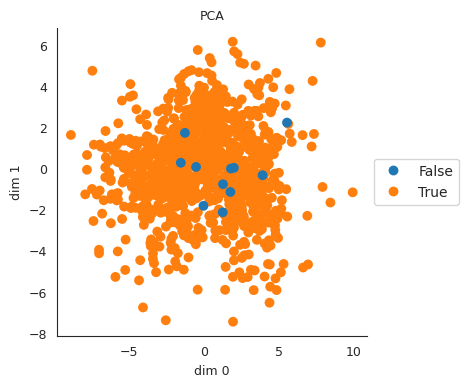

In [22]:
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="seen_during_training", circle_size=50)

Now we can colorize it according to donor and see that the first two principal component captures the variability across donors ...

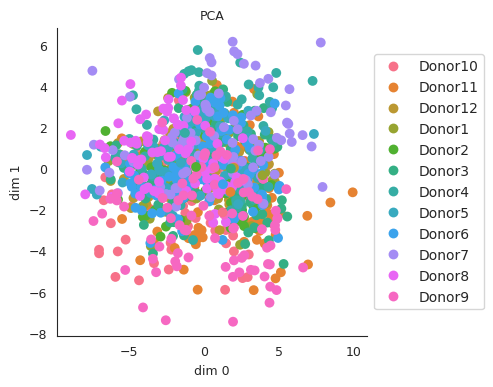

In [23]:
df_condition_embedding["condition"] = df_condition_embedding.index
df_condition_embedding["donor"] = df_condition_embedding.apply(lambda x: x["condition"].split("_")[0], axis=1)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="donor", circle_size=50)

... and across cytokine treatments.

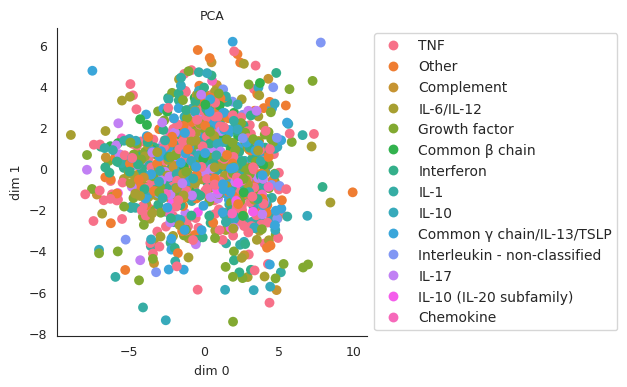

In [24]:
df_cytos = adata.obs.drop_duplicates(subset=["cytokine"])
cyto_to_family = dict(df_cytos.set_index('cytokine')['cytokine_family'])
    
df_condition_embedding["cytokine"] = df_condition_embedding.apply(lambda x: "_".join(x["condition"].split("_")[1:]), axis=1)
df_condition_embedding["cytokine_family"] = df_condition_embedding["cytokine"].map(cyto_to_family)
fig = plot_condition_embedding(df_condition_embedding, embedding="PCA", hue="cytokine_family", circle_size=50, legend=False)


## Predicting with CellFlow

Predictions with CellFlow require an {class}`adata <anndata.AnnData>` object with control cells; these can correspond to different sample covariates, i.e. to different donors. Moreover, we require `covariate_data` which are conditions which we would like to predict. In our case, we would like to predict the response to IL-15 from all donors which haven't been seen during training. For the sake of computational speed, we leverage our subsampled data containing 500 control cells per donor. As we only want to make counterfactual predictions for control cells, we have to filter the previously defined `adata_test_for_validation` to control cells only.

In [25]:
adata_ctrl_for_prediction = adata_test_for_validation[adata_test_for_validation.obs["is_control"].to_numpy()]
adata_ctrl_for_prediction.obs["condition"].unique()

array(['Donor10_PBS', 'Donor11_PBS', 'Donor12_PBS', 'Donor1_PBS',
       'Donor2_PBS', 'Donor3_PBS', 'Donor4_PBS', 'Donor5_PBS',
       'Donor6_PBS', 'Donor7_PBS', 'Donor8_PBS', 'Donor9_PBS'],
      dtype=object)

The covariate data is supposed to contain the conditions which we would like to transform the source cells into:

In [26]:
covariate_data_il15 = adata_test_for_validation[~adata_test_for_validation.obs["is_control"].to_numpy()].obs.drop_duplicates(subset=["condition"])
covariate_data_il15.head()

,sample,species,gene_count,tscp_count,mread_count,bc1_wind,bc2_wind,bc3_wind,bc1_well,bc2_well,...,total_counts_MT,pct_counts_MT,log1p_total_counts_MT,donor,cytokine,treatment,cell_type,cytokine_family,condition,is_control
11_151_069__s141,Donor10_IL-15,hg38,2783,6570,14045,11,151,69,A11,p2.E7,...,90.0,1.369863,4.510859,Donor10,IL-15,cytokine,CD14 Mono,Common γ chain/IL-13/TSLP,Donor10_IL-15,False
11_105_016__s29,Donor11_IL-15,hg38,1811,3352,6614,11,105,16,A11,p2.A9,...,41.0,1.223150,3.737670,Donor11,IL-15,cytokine,CD4 Naive,Common γ chain/IL-13/TSLP,Donor11_IL-15,False
11_192_045__s45,Donor12_IL-15,hg38,732,1047,2236,11,192,45,A11,p2.H12,...,61.0,5.826170,4.127134,Donor12,IL-15,cytokine,B Naive,Common γ chain/IL-13/TSLP,Donor12_IL-15,False
11_002_126__s118,Donor1_IL-15,hg38,2795,7518,13960,11,2,126,A11,A2,...,105.0,1.396648,4.663439,Donor1,IL-15,cytokine,CD4 Naive,Common γ chain/IL-13/TSLP,Donor1_IL-15,False
11_064_074__s56,Donor2_IL-15,hg38,2330,4459,9349,11,64,74,A11,F4,...,43.0,0.964342,3.784190,Donor2,IL-15,cytokine,CD4 Memory,Common γ chain/IL-13/TSLP,Donor2_IL-15,False


Now we can compute the predicted cellular states of IL-15 treatments for all donors which we haven't seen during training. Again, we specify where the cellular data is stored via `sample_rep`, and provide a `condition_id_key` which defines the keys of the returned dictionary containing the predictions.

In [27]:
preds = cf.predict(adata=adata_ctrl_for_prediction, sample_rep="X_pca", condition_id_key="condition", covariate_data=covariate_data_il15)

100%|██████████| 1/1 [00:00<00:00, 826.30it/s]


We now build an {class}`adata <anndata.AnnData>` object to store the predictions in {attr}`adata.obsm <anndata.AnnData.obsm>`:

In [ ]:
adata_preds = []
for cond, array in preds.items():
    
    obs_data = pd.DataFrame({
        'condition': [cond] * array.shape[0]
    })
    adata_pred = ad.AnnData(X=np.empty((len(array),adata_train.n_vars)), obs=obs_data)
    adata_pred.obsm["X_pca"] = np.squeeze(array)
    adata_preds.append(adata_pred)

adata_preds = ad.concat(adata_preds)
adata_preds.var_names = adata_train.var_names

We now transfer labels using the 1NN classifier based on the training data. Therefore, we first have to compute a nearest neighbor graph, and then transfer the labels subsequently. Note that for the sake of computational speed, we here use subsampled training data `adata_train_for_validation`.

In [ ]:
compute_wknn(ref_adata=adata_train_for_validation, query_adata=adata_preds, n_neighbors=1, ref_rep_key="X_pca", query_rep_key="X_pca")
transfer_labels(query_adata=adata_preds, ref_adata=adata_train_for_validation, label_key="cell_type")

We now reconstruct the cells generated in PCA space to gene space:

In [ ]:
reconstruct_pca(query_adata=adata_preds, use_rep="X_pca", ref_adata=adata_train, layers_key_added="X_recon")
adata_preds.layers

Layers with keys: X_recon

Now, we can plot our predictions together with transferred cell types, and compare it to the true cells, and a subset of the training data.

In [ ]:
adata_preds.obs["donor"] = adata_preds.obs.apply(lambda x: x["condition"].split("_")[0], axis=1)
adata_preds.obs["cytokine"] = adata_preds.obs.apply(lambda x: "_".join(x["condition"].split("_")[1:]), axis=1)
adata_preds.obs["cell_type"] = adata_preds.obs["cell_type_transfer"]
adata_preds.X = adata_preds.layers["X_recon"]
del adata.layers

adata_preds.obs["mode"] = "generated"
adata_train_for_validation.obs["mode"] = "train"
adata_test_for_validation.obs["mode"] = "test"

adata_concatenated = ad.concat((adata_preds, adata_train_for_validation, adata_test_for_validation[~adata_test_for_validation.obs["is_control"].to_numpy()]))

rsc.pp.pca(adata_concatenated)
rsc.pp.neighbors(adata_concatenated)
rsc.tl.umap(adata_concatenated)


[2025-04-04 14:43:56.716] [CUML] [debug] n_neighbors=15
[2025-04-04 14:43:56.826] [CUML] [debug] Calling knn graph run
[2025-04-04 14:43:56.826] [CUML] [debug] Done. Calling fuzzy simplicial set
[2025-04-04 14:43:57.696] [CUML] [debug] Done. Calling remove zeros


For a visual assessment, we compare true cells with generated cells on a UMAP

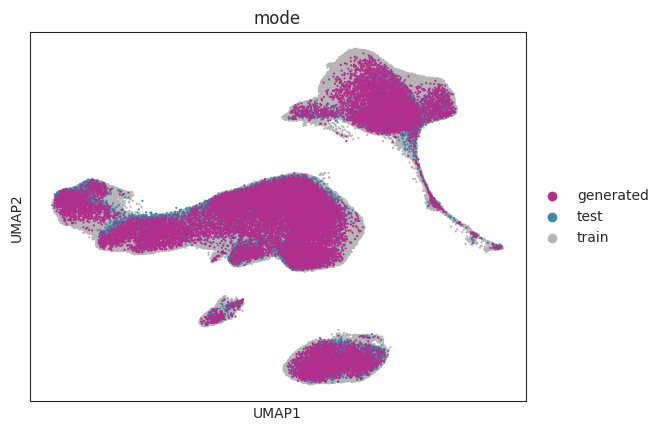

In [ ]:
adata_concatenated.obs["condition_mode"] = adata_concatenated.obs.apply(lambda x: x["condition"] + "_" + x["mode"], axis=1)
adata_concatenated.obs.reset_index(inplace=True)

color_palette = {"generated": "#B12F8C", "test": "#3F8AA6", "train": "#B6B6B6"}
order = list(adata_concatenated[adata_concatenated.obs["mode"]=="train"].obs_names) + list(adata_concatenated[adata_concatenated.obs["mode"]=="test"].obs_names) + list(adata_concatenated[adata_concatenated.obs["mode"]=="generated"].obs_names)
sc.pl.umap(adata_concatenated[order], color=["mode"], palette=color_palette, size=10)

We can also compare the true with the predicted population donor-specifically, together with a comparison to the control distribution, hence visualising both the donor effect and the perturbation effect. Qualitatively, the magenta (predicted) distribution should be closer to the blue (true) distribution than to the black (control) distribution.

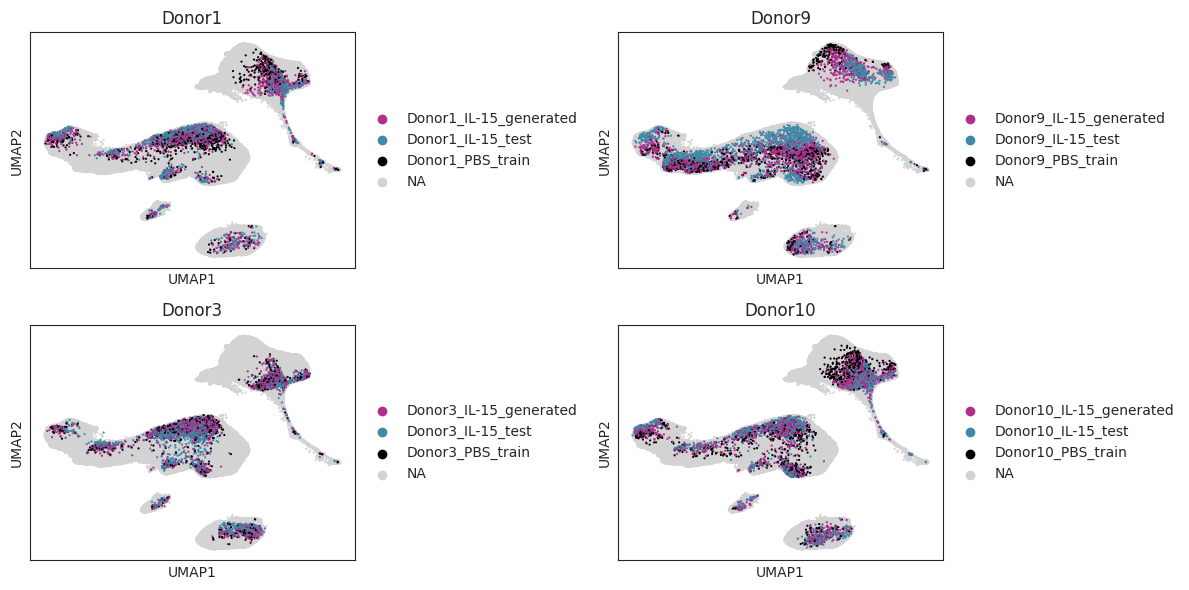

In [ ]:
def plot_umap_highlight(adata, donor_id, ax):
    groups_to_visualize = [f"{donor_id}_PBS_train", f"{donor_id}_IL-15_test", f"{donor_id}_IL-15_generated"]
    
    # Define color palette
    color_palette = {k: "#B6B6B6" for k in adata.obs["condition_mode"].unique()}
    color_palette.update({
        f"{donor_id}_IL-15_generated": "#B12F8C",
        f"{donor_id}_IL-15_test": "#3F8AA6",
        f"{donor_id}_PBS_train": "#000000",
    })
    obs_to_highlight = list(adata[adata.obs["condition_mode"].isin(groups_to_visualize)].obs_names)
    np.random.shuffle(obs_to_highlight)
    order = list(adata[~adata.obs["condition_mode"].isin(groups_to_visualize)].obs_names) + \
            obs_to_highlight
    
    sc.pl.umap(
        adata[order],
        color="condition_mode",
        groups=groups_to_visualize,
        palette=color_palette,
        size=10,
        ax=ax,
        show=False,
        title=donor_id
    )

donors = ["Donor1", "Donor9", "Donor3", "Donor10"]
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs = axs.flatten()

for i, donor in enumerate(donors):
    plot_umap_highlight(adata_concatenated, donor, axs[i])

plt.tight_layout()
plt.show()


We can also inspect the predicted gene expression next to the true gene expression, e.g. of the IL-15 treated CD14 differentially expressed gene IDO1.

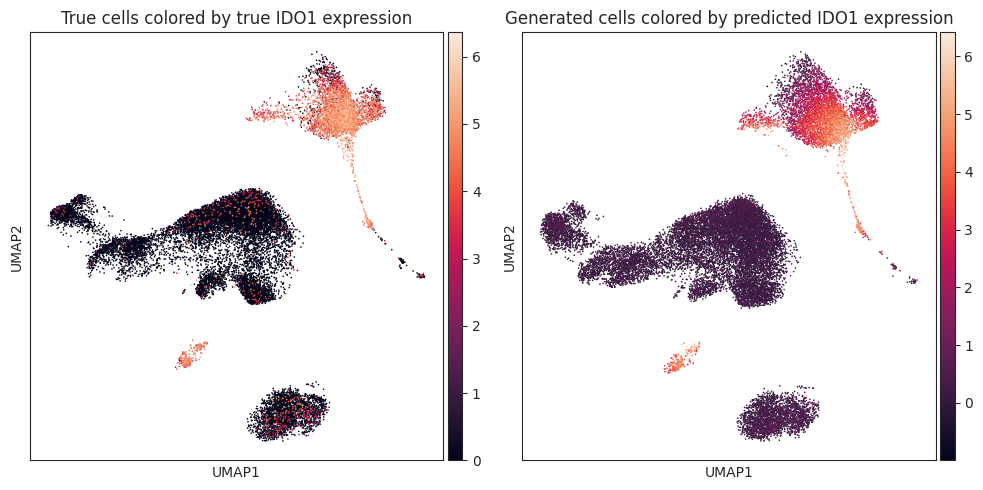

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sc.pl.umap(
    adata_concatenated[adata_concatenated.obs["mode"] == "test"],
    color=["IDO1"],
    ax=axs[0],
    show=False,
    title="True cells colored by true IDO1 expression"
)
sc.pl.umap(
    adata_concatenated[adata_concatenated.obs["mode"] == "generated"],
    color=["IDO1"],
    ax=axs[1],
    show=False,
    title="Generated cells colored by predicted IDO1 expression"
)
plt.tight_layout()
plt.show()


Finally, we compute a few metrics. For evaluation of distributional metrics, we compute a lower-dimensional PCA space from the entire dataset (including the test data). For computational reasons, we subsample the entire dataset first, compute a PCA embedding, and subsequently project both the true and the generated cells onto it.

In [ ]:
adata_ref = sc.pp.subsample(adata, n_obs=100_000, copy=True)
cfpp.centered_pca(adata_ref, n_comps=30, method="rapids")
adata_true = adata_test_for_validation[~adata_test_for_validation.obs["is_control"].to_numpy()]
cfpp.project_pca(query_adata=adata_preds, ref_adata=adata_ref)
cfpp.project_pca(query_adata=adata_true, ref_adata=adata_ref)


In [ ]:
test_data_target_encoded = {}
test_data_target_decoded = {}
test_data_target_encoded_predicted = {}
test_data_target_decoded_predicted = {}

for cond in adata_preds.obs["condition"].unique():
    test_data_target_encoded[cond] = adata_true[adata_true.obs["condition"] == cond].obsm["X_pca"]
    test_data_target_decoded[cond] = adata_true[adata_true.obs["condition"] == cond].X.toarray()
    test_data_target_encoded_predicted[cond] = adata_preds[adata_preds.obs["condition"] == cond].obsm["X_pca"]
    test_data_target_decoded_predicted[cond] = adata_preds[adata_preds.obs["condition"] == cond].X


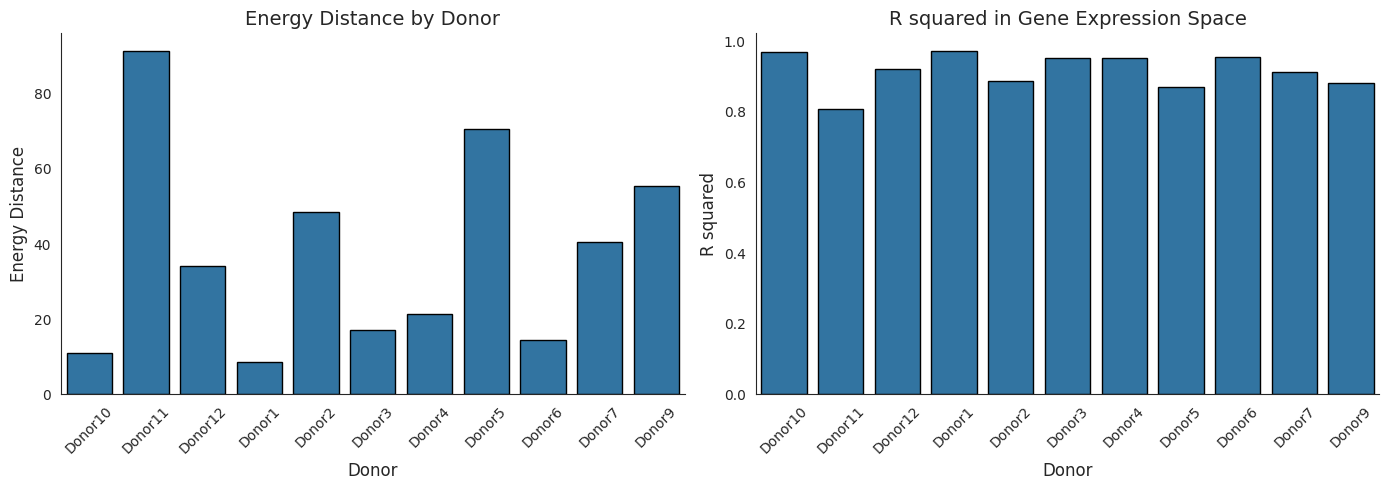

In [ ]:
e_distances = jax.tree_util.tree_map(
    compute_e_distance, test_data_target_encoded, test_data_target_encoded_predicted
)

r_squared = jax.tree_util.tree_map(
    compute_r_squared, test_data_target_decoded, test_data_target_decoded_predicted
)

df_e_distance = pd.DataFrame.from_dict(e_distances, orient="index", columns=["energy_distance"])
df_r_squared = pd.DataFrame.from_dict(r_squared, orient="index", columns=["r_squared"])
df_metrics = pd.merge(df_e_distance, df_r_squared, left_index=True, right_index=True)
df_metrics["condition"] = df_metrics.index
df_metrics["donor"] = df_metrics.apply(lambda x: x["condition"].split("_")[0], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.barplot(
    data=df_metrics,
    x="donor",
    y="energy_distance",
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Energy Distance by Donor", fontsize=14)
axes[0].set_xlabel("Donor", fontsize=12)
axes[0].set_ylabel("Energy Distance", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(
    data=df_metrics,
    x="donor",
    y="r_squared",
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("R squared in Gene Expression Space", fontsize=14)
axes[1].set_xlabel("Donor", fontsize=12)
axes[1].set_ylabel("R squared", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

sns.despine()
plt.tight_layout()
plt.show()
